---
layout: post
title:  "Evolution of US COVID-19 cases"
desc: "Practise with pandas, python and plotly."
date: ###DATE
categories: [tutorial]
tags: [plotting]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/uscovidevolution"

---

This plot was first [inspired by this absolute masterpiece of a visualisation](https://www.reddit.com/r/dataisbeautiful/comments/hl20sz/watch_covid19_spread_throughout_the_continental/). I was chatting with [David Morton](https://github.com/DavidMorton) about how much work it must have taken (coding up textures, exporting to blender, creating the model, rendering, compositing, loading back into code, annotating, so much work). David then went and [created a python only version of the plot](https://github.com/DavidMorton/COVID-19-Analysis), and I decided I'd give it a crack too. We've used the same data, but the transformations, plotting and output are all different.

Here's what we'll be making:

In [2]:
from IPython.display import Video
Video("us_covid_evolution/evolution.mp4")


To start, I cloned down the Johns Hopkins [COVID-19 repo](https://github.com/CSSEGISandData/COVID-19). I then added into the `root` dir shown below both the [population counts](https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html) for ech county, and the [`geojson`](https://github.com/plotly/datasets/blob/master/geojson-counties-fips.json) file that allows us to plot said counties.

In [3]:
import os
import pandas as pd
import numpy as np
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt
import cmasher as cmr
import plotly.express as px
import plotly.graph_objects as go
from functools import lru_cache

# Dir where you clone out https://github.com/CSSEGISandData/COVID-19
root = "D:/data/covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"

Then, lets find all the csv files for the US states and load them in.

In [4]:
df = pd.read_csv(os.path.join(root, "time_series_covid19_confirmed_US.csv"))
print(df.columns)

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '7/2/20', '7/3/20', '7/4/20', '7/5/20', '7/6/20', '7/7/20', '7/8/20',
       '7/9/20', '7/10/20', '7/11/20'],
      dtype='object', length=183)


Right, so its sort of pivoted already. But I dont actually want this, because I want smooth interpolation. I want dates on the index, and FIPS on the columns. On top of that, I want the relative increase in number of cases per 100k residents, or we'll just be [replicating a population map](https://xkcd.com/1138/).

So first, lets get the estimate population of each FIPS:

In [5]:
# Load the population for each county
df_pop = pd.read_csv(os.path.join(root, "co-est2019-alldata.csv"), encoding="ISO-8859-1")
df_pop["FIPS"] = (df_pop["STATE"] * 1000 + df_pop["COUNTY"]).apply("{:0>5}".format)
df_pop = df_pop[["FIPS", "POPESTIMATE2019"]]
df_pop

,FIPS,POPESTIMATE2019
0,01000,4903185
1,01001,55869
2,01003,223234
3,01005,24686
4,01007,22394
...,...,...
3188,56037,42343
3189,56039,23464
3190,56041,20226
3191,56043,7805


Great, lets merge that in. In addition, you know, to melting, converting units and smoothing it out.

In [6]:
# Determine useless columns
drop = [x for x in df.columns if "/" not in x and x != "FIPS"]

# Melt it down so we can convert types easily
df2 = df.drop(columns=drop).melt(id_vars="FIPS", var_name="date").dropna()
df2["date"] = pd.to_datetime(df2["date"])
df2["FIPS"] = df2["FIPS"].astype(int).apply("{:0>5}".format)

# Add the populations
df2 = df2.merge(df_pop, on="FIPS")
df2["value"] = 100000 * df2["value"] / df2["POPESTIMATE2019"]

# Pivot and get the difference
df2 = df2.pivot(columns="FIPS", index="date", values="value").diff(axis=0)
# Smooth it out a touch and remove some 0 rows
df2 = df2.rolling(7).mean().iloc[50:, :]

We've got the data in a format we want. But I'll also want to turn this into a shiny animation, probably around 10 seconds in length or more. At 30FPS, thats 300+ frames. More than we have rows. So time for interpolation!

In [7]:
fr = 30  # frame rate
t = 12  # seconds
new_index = pd.date_range(df2.index.min(), df2.index.max(), fr * t)

# Combine index, interp, remove original index
df3 = df2.reindex(new_index | df2.index).interpolate().loc[new_index]
df3.iloc[:5, :5]

FIPS,01001,01003,01005,01007,01009
2020-03-12 00:00:00.000000000,0.0,0.0,0.0,0.0,0.0
2020-03-12 08:05:20.891364902,0.0,0.0,0.0,0.0,0.0
2020-03-12 16:10:41.782729805,0.0,0.0,0.0,0.0,0.0
2020-03-13 00:16:02.674094707,0.0,0.0,0.0,0.0,0.0
2020-03-13 08:21:23.565459610,0.0,0.0,0.0,0.0,0.0


Perfect. So now lets make a plot for this:

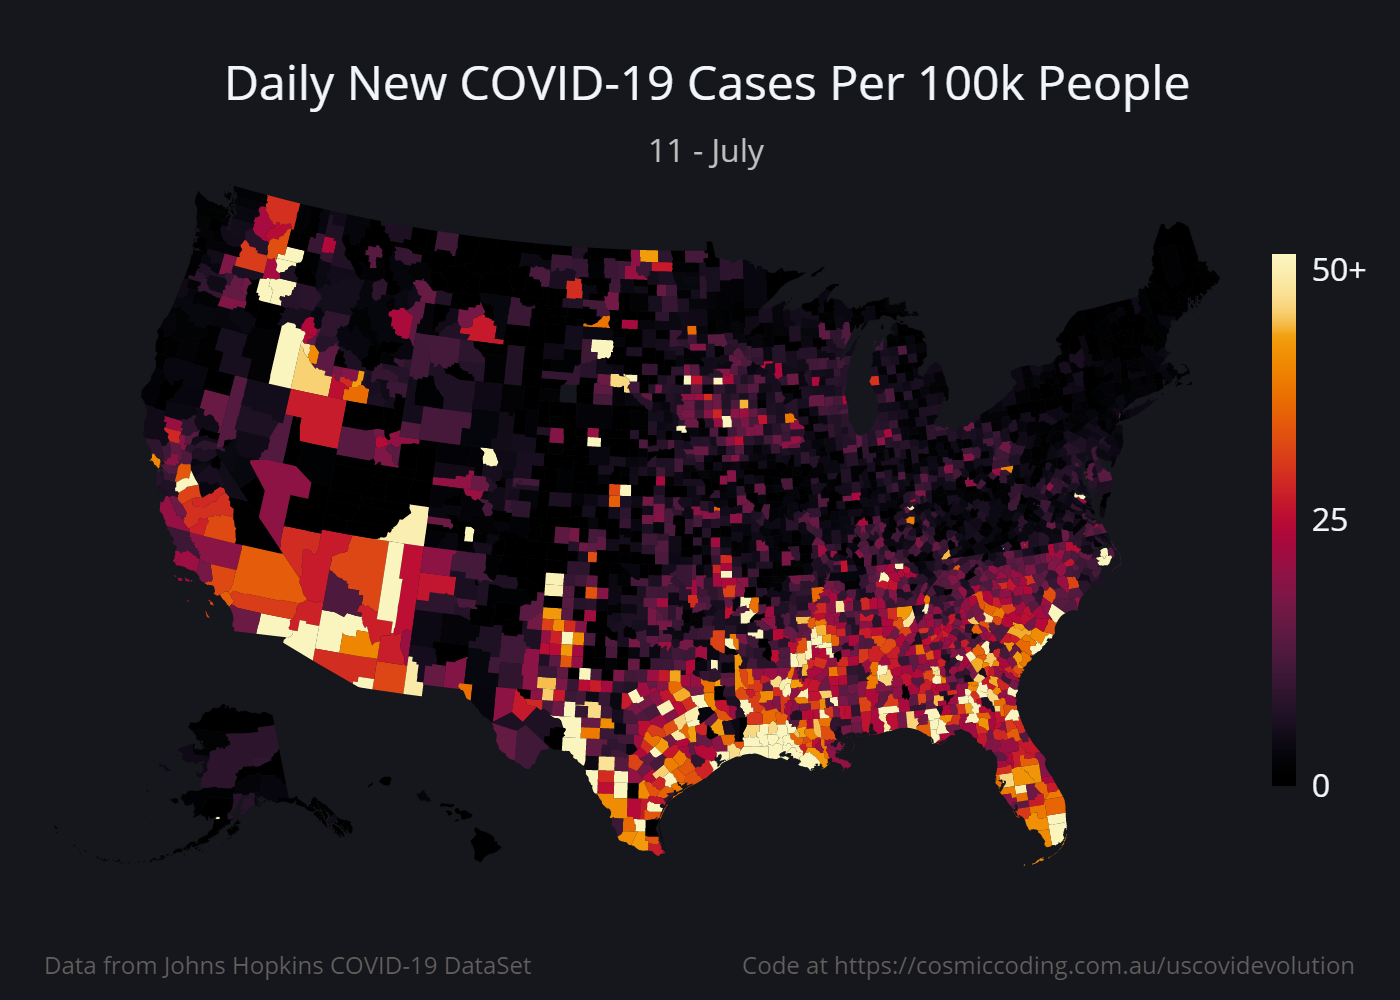

In [8]:
@lru_cache(maxsize=1)
def get_all_counties():
    with open(os.path.join(root, 'geojson-counties-fips.json')) as f:
        allcounties = json.load(f)
    return allcounties

@lru_cache(maxsize=1)
def get_cmap():
    """ Gets am ember-like cmap with brighter tail """
    cmap = plt.get_cmap('cmr.ember')
    array = 1 - cmap(np.linspace(0, 1, 100))
    brightening = np.clip(np.linspace(-10, 3, 100), 1, 4)
    final = np.clip(1 - (array / brightening[:, None]), 0, 1)
    return [to_hex(x) for x in final]

def default_configure(fig, date, vmax, bgcolor="#15171c"):
    """ Visual styling and labels, ignore this function as its boring """
    fig.update_geos(showcountries=False, showcoastlines=False, showframe=False,
                    oceancolor=bgcolor, lakecolor=bgcolor, showland=False, showlakes=False, 
                    showocean=False,subunitcolor=bgcolor, landcolor=bgcolor, bgcolor=bgcolor)
    fig.update_traces(marker_line_width=0, showscale=False)
    annotations = [
    dict(x=0.03,y=-0.03,font=dict(color="#635f5d",size=12),showarrow=False,
        text='Data from Johns Hopkins COVID-19 DataSet',
        xref="paper",yref="paper", yanchor="bottom"),
    dict(x=1.0,y=-0.03,font=dict(color="#635f5d",size=12),showarrow=False,
        text='Code at https://cosmiccoding.com.au/uscovidevolution',
        xref="paper",yref="paper", xanchor="right", yanchor="bottom"),
    dict(x=0.52, y=1.04, yanchor='top', xanchor='center', font=dict(size=24),
         showarrow=False, text='Daily New COVID-19 Cases Per 100k People', xref="paper", yref="paper"),
    dict(x=0.52, y=0.95, yanchor='top', xanchor='center', font=dict(color="#bfbfbf", size=16),
     showarrow=False, text=date, xref="paper", yref="paper")
    ]
    fig.update_layout(plot_bgcolor=bgcolor, paper_bgcolor=bgcolor,
                      margin={"r": 20,"t":40,"l":0,"b":20}, annotations=annotations,
                     coloraxis_colorbar=dict(thicknessmode="pixels", thickness=12, ticks="", 
                                             tickmode="array", 
                                             ticktext=[" 0", f" {int(vmax / 2)}", f" {vmax}+"], 
                                             tickvals=[0, int(vmax/2), 0.97 * vmax],
                                             x=0.92, y=0.5,
                                             tickfont=dict(size=16),
                                             len=0.65))

def save_fig(fig, n):
    out = "us_covid_evolution/png"
    os.makedirs(out, exist_ok=True)
    fig.write_image(os.path.join(out, f"{n:0>4}.png"), scale=3)

def plot_row(df, row, vmax=50, show=False):
    tmp = df.iloc[row, :].T.reset_index()
    date = tmp.columns[1].strftime("%d - %B")
    tmp.columns = ["FIPS", "c"]
    fig = px.choropleth(tmp, geojson=get_all_counties(), locations='FIPS', 
                        color="c", color_continuous_scale=get_cmap(), labels={"c": ""},
                        scope="usa", range_color=(0, vmax), template='plotly_dark')
    default_configure(fig, date, vmax)
    save_fig(fig, row)
    return fig
        
# Lets just plot the final frame to make sure it looks good   
n = df3.shape[0] - 1
fig = plot_row(df3, n, show=True)

# Want a PNG, not interactive
from IPython.display import Image
Image(fig.to_image(format="png", scale=2))

!!!main poster

What an image! Now to save out a whole bunch of images. I'm doing this in a notebook, but `joblib` still works with the threading back end.

In [9]:
from joblib import Parallel, delayed
Parallel(prefer="threads", n_jobs=4)(delayed(plot_row)(df3, n) for n in range(df3.shape[0]))

KeyboardInterrupt: 

And now that we have a PNG sequence, lets render it out to an mp4 file. Im going to also add a mask (which is black but transparent over the country and colorbar that I want to glow, I threw it together in photoshop) and some complex filters to emulate a glow effect without having to throw it in After Effects, and it also makes it pause on the last frame for a bit without having to rend out things over and over.

```
ffmpeg -r 30 -i us_covid_evolution/png/%04d.png -i us_covid_evolution/mask.png -filter_complex "      [1]setsar=sar=0[p],
[0]split[a][b],
[a][p]overlay,lumakey=0:tolerance=0.5:softness=0.5[x];
color=black,format=rgb24[c];
[c][x]scale2ref[c][i];
[c][i]overlay=format=auto:shortest=1,
setsar=sar=1,
gblur=30:3,
curves=all='0/0 1/1'[d],
[b]setsar=sar=1[e],
[d][e]blend=all_mode=addition,
scale=1920:-2,
tpad=stop_mode=clone:stop_duration=2
" -vcodec libx264 -crf 23 -movflags faststart -pix_fmt yuv420p us_covid_evolution/evolution.mp4
```

For a super brief explanation of the `-filter_complex`:
* Load in the mask and overlay it on the image so that the black "blacks-out" the parts I dont want
* lumakey then makes sure anything dim becomes transparent, so it wont glow
* Merge a black solid on top
* Apply a guassian glur
* Intensity the blurred image
* Add it on top of the original image
* Rescale it to 1920 pixels wide
* Add 2 seconds of video at the end which is the last frame frozen out.

After that has run, we should have a nice animated version of the PNG sequence! In fact, I'll put the video up the top as well. If you dont want the glow, the entire filter can just be the scaling the the `tpad`, much simpler. Heres the final product:



In [1]:
from IPython.display import Video
Video("us_covid_evolution/evolution.mp4")